# Table of Contents

## 1. Loading the Data

In [17]:
# import torch
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

In [18]:
with open("Kinderlieder.txt", 'r', encoding='utf-8') as f:
    text = f.read()

In [19]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print('vocab_size=', vocab_size)


 !()*,-.02345678:;?ABCDEFGHIJKLMNOPRSTUVWZabcdefghijklmnoprstuvwxyz´Üßäöü‘’“”…
vocab_size= 79


## 2. Tokenization

In [20]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
print(itos)

{0: '\n', 1: ' ', 2: '!', 3: '(', 4: ')', 5: '*', 6: ',', 7: '-', 8: '.', 9: '0', 10: '2', 11: '3', 12: '4', 13: '5', 14: '6', 15: '7', 16: '8', 17: ':', 18: ';', 19: '?', 20: 'A', 21: 'B', 22: 'C', 23: 'D', 24: 'E', 25: 'F', 26: 'G', 27: 'H', 28: 'I', 29: 'J', 30: 'K', 31: 'L', 32: 'M', 33: 'N', 34: 'O', 35: 'P', 36: 'R', 37: 'S', 38: 'T', 39: 'U', 40: 'V', 41: 'W', 42: 'Z', 43: 'a', 44: 'b', 45: 'c', 46: 'd', 47: 'e', 48: 'f', 49: 'g', 50: 'h', 51: 'i', 52: 'j', 53: 'k', 54: 'l', 55: 'm', 56: 'n', 57: 'o', 58: 'p', 59: 'r', 60: 's', 61: 't', 62: 'u', 63: 'v', 64: 'w', 65: 'x', 66: 'y', 67: 'z', 68: '´', 69: 'Ü', 70: 'ß', 71: 'ä', 72: 'ö', 73: 'ü', 74: '‘', 75: '’', 76: '“', 77: '”', 78: '…'}


In [21]:
# Store the encoded text in a torch.tensor
data = torch.tensor(encode(text), dtype=torch.long)
print("Shape of data:", data.shape)
print("Dtype of data:", data.dtype)

Shape of data: torch.Size([21044])
Dtype of data: torch.int64


## 3. Making Training Mini-Batches

In [22]:
train_data = data[:int(len(data)*0.9)]
print ("Length of the training data:",len(train_data))

val_data = data[int(len(data)*0.9):]
print ("Length of the validation data:",len(val_data))

print("Check against total length; must be equal 0: (len(data) - len(train_data)-len(val_data)):", len(data)-len(train_data)-len(val_data))

Length of the training data: 18939
Length of the validation data: 2105
Check against total length; must be equal 0: (len(data) - len(train_data)-len(val_data)): 0


## 8. Full GPT Implementation

Find below the hyperparameters:

| Hyperparameter | Main Effect                                              |
|----------------|----------------------------------------------------------|
| batch_size     | Number of sequences in the batch (parallelism and efficiency). |
| block_size     | Maximum context length (sequence length).                |
| max_iters      | Maximum number of training steps.                        |
| eval_interval  | Frequency of evaluation (training feedback).             |
| learning_rate  | Step size for parameter updates.                         |
| eval_iters     | Amount of iterations taken into account for average loss evaluation                   |
| n_embd         | Dimension of embeddings (model capacity).                |
| n_head         | Number of parallel attention heads.                      |
| n_layer        | Number of transformer blocks.                            |
| dropout        | Regularization to prevent overfitting.                   |
| device         | Execution device (computational speed).                  |

In [110]:
# Define all hyperparameters in a dictionary
hyperparameters = {
    "name": "original_CPU",
    "batch_size": 16,
    "block_size": 32,
    "max_iters": 5000,
    "eval_interval": 500,
    "learning_rate": 1e-3,
    "eval_iters": 200,
    "n_embd": 64,
    "n_head": 4,
    "n_layer": 4,
    "dropout": 0.2,
    "device": "mps",
}

# Access hyperparameters dynamically
name = hyperparameters["name"]
batch_size = hyperparameters["batch_size"]
block_size = hyperparameters["block_size"]
max_iters = hyperparameters["max_iters"]
eval_interval = hyperparameters["eval_interval"]
learning_rate = hyperparameters["learning_rate"]
eval_iters = hyperparameters["eval_iters"]
n_embd = hyperparameters["n_embd"]
n_head = hyperparameters["n_head"]
n_layer = hyperparameters["n_layer"]
dropout = hyperparameters["dropout"]
device = hyperparameters["device"]

print(hyperparameters)

{'name': 'original_CPU', 'batch_size': 16, 'block_size': 32, 'max_iters': 5000, 'eval_interval': 500, 'learning_rate': 0.001, 'eval_iters': 200, 'n_embd': 64, 'n_head': 4, 'n_layer': 4, 'dropout': 0.2, 'device': 'mps'}


In [111]:
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data # 
    ix = torch.randint(len(data) - block_size, (batch_size,)) # 
    x = torch.stack([data[i:i+block_size] for i in ix]) # 
    y = torch.stack([data[i+1:i+block_size+1] for i in ix]) # 
    x, y = x.to(device), y.to(device) # 
    return x, y #

@torch.no_grad() # we don't need gradients for this function (more efficient)
def estimate_loss(): # average loss over eval_iters iterations
    out = {}
    model.eval() # switch to eval mode
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train() # switch back to train mode
    return out

class Head(nn.Module): #

    def __init__(self, head_size): # 
        super().__init__() # 
        self.key = nn.Linear(n_embd, head_size, bias=False) # 
        self.query = nn.Linear(n_embd, head_size, bias=False) # 
        self.value = nn.Linear(n_embd, head_size, bias=False) # 
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size))) # 

        self.dropout = nn.Dropout(dropout) # 

    def forward(self, x): # 
        B,T,C = x.shape # 
        k = self.key(x)   # 
        q = self.query(x) # 

        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # 
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # 
        wei = F.softmax(wei, dim=-1) # 
        wei = self.dropout(wei) # 
        
        v = self.value(x) # 
        out = wei @ v # 
        
        return out # 

class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, head_size): 
        super().__init__() # 
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)]) # 
        self.proj = nn.Linear(n_embd, n_embd) #
        self.dropout = nn.Dropout(dropout) # 
        
    def forward(self, x): # 
        out = torch.cat([h(x) for h in self.heads], dim=-1) # 
        out = self.dropout(self.proj(out)) # 
        return out # 

class FeedFoward(nn.Module):

    def __init__(self, n_embd): #
        super().__init__() # 
        self.net = nn.Sequential( # 
            nn.Linear(n_embd, 4 * n_embd), # 
            nn.ReLU(), # 
            nn.Linear(4 * n_embd, n_embd), # 
            nn.Dropout(dropout), # 
        )

    def forward(self, x): # 
        return self.net(x) # 

class Block(nn.Module):

    def __init__(self, n_embd, n_head): # 
        super().__init__() # 
        head_size = n_embd // n_head # 
        self.sa = MultiHeadAttention(n_head, head_size) # 
        self.ffwd = FeedFoward(n_embd) # 
        self.ln1 = nn.LayerNorm(n_embd) # 
        self.ln2 = nn.LayerNorm(n_embd) # 

    def forward(self, x):
        x = x + self.sa(self.ln1(x)) # 
        x = x + self.ffwd(self.ln2(x)) #
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__() # 
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # 
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # 
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)]) # 
        self.ln_f = nn.LayerNorm(n_embd) # 
        self.lm_head = nn.Linear(n_embd, vocab_size) # 

    def forward(self, idx, targets=None): # 
        B, T = idx.shape # 

        tok_emb = self.token_embedding_table(idx) # 
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # 
        x = tok_emb + pos_emb # 
        x = self.blocks(x) # 
        x = self.ln_f(x) # 
        logits = self.lm_head(x) # 

        if targets is None: # 
            loss = None # 
        else:
            B, T, C = logits.shape # 
            logits = logits.view(B*T, C) # 
            targets = targets.view(B*T) # 
            loss = F.cross_entropy(logits, targets) # 

        return logits, loss # 

    def generate(self, idx, max_new_tokens): # 
        for _ in range(max_new_tokens): # 
            idx_cond = idx[:, -block_size:] # 
            logits, loss = self(idx_cond)  # 
            logits = logits[:, -1, :] # 
            probs = F.softmax(logits, dim=-1) # 
            idx_next = torch.multinomial(probs, num_samples=1) # 
            idx = torch.cat((idx, idx_next), dim=1) # 
        return idx


model = GPTLanguageModel() # 
model = model.to(device) # 

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters') # 

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate) # 

train_losses = []  # storage for training losses
val_losses = []    # storag for validation losses

for iter in range(max_iters+1): # training loop

    if iter % eval_interval == 0 or iter == max_iters: # evaluate the model
        losses = estimate_loss() # calculate the average loss over eval_iters iterations
        train_losses.append(losses['train'].item())  # store the training loss
        val_losses.append(losses['val'].item())      # store the validation loss
        print("\n==============")
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}") # 
        print("==============")
        
        print("\nSample:")
        context = torch.zeros((1, 1), dtype=torch.long, device=device) # 
        print(decode(model.generate(context, max_new_tokens=200)[0].tolist())) # 

    xb, yb = get_batch('train') #

    logits, loss = model(xb, yb) # 
    optimizer.zero_grad(set_to_none=True) # 
    loss.backward() # 
    optimizer.step() #


0.211535 M parameters

step 0: train loss 4.4581, val loss 4.4650

Sample:

-7vVO*D‘‘WDeöi…‘PlOADD5xPx-“*BMnP5”N-B“D4,yü6bFCtDb Z6vsL
“6AU:KO6G0’.J()s?xncGPwMD ö2röHkO´A8”RGRwi,cüvp,olA?lhIj*’07ck3wj”-4ß“IAiyDgz2Nbß“kä,.2e68;,opPkn´.eI4´kö´M!owdZNPA?
:hwN-ftG7zVhKuiü;MF5’Cükc

step 500: train loss 2.1016, val loss 2.2409

Sample:

t kur,
Draussle dimein wa,
Auf wig,
kt mien meiromen Drm!
3.
2.
Jrichich, mer iustistzim ger Bar.
Echkort mein fein hus Beigehn
Blene Lall ge Tochot!
un dwach.
Alich s Ko*.
Dalen
2.

2.
Les Mase s wei

step 1000: train loss 1.7556, val loss 2.1075

Sample:

Kruckommmt nickund Koß.
kialaf allaab’s Marruen ung istrag,
wir d,
stem Schaba, ballin war under.
’n wan
2.
3.
3.
Wast weid sin.
Werken se sein voglle die me
2.
Bine salad min nier, Kisss mt ander s A

step 1500: train loss 1.5155, val loss 2.0864

Sample:

re Arge, timen
Und rie St geige.

Allchten bmelt dvim Miein,
schühe fen in Weist ihr nach,
die Taum Wallsisli,
ind ich frohen blinne uns und der dieber

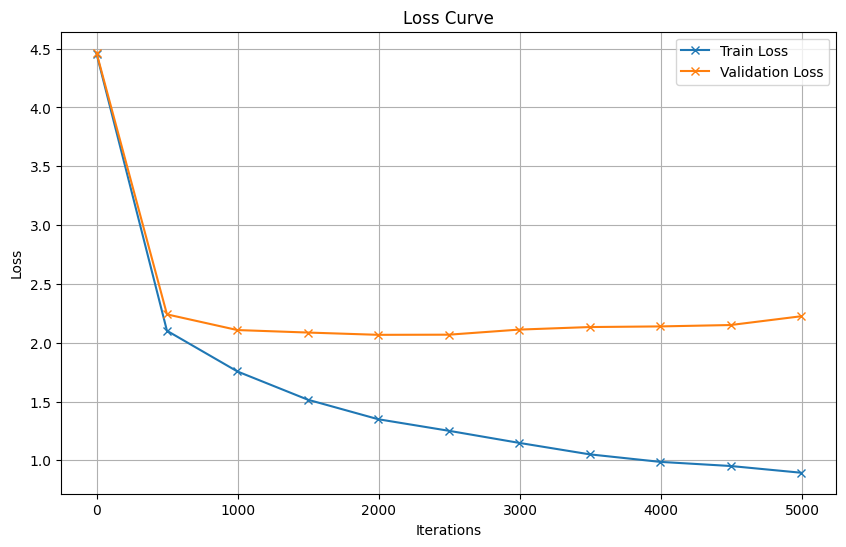

In [112]:
import matplotlib.pyplot as plt

iterations = list(range(len(train_losses)))
plt.figure(figsize=(10, 6))
plt.plot(range(0, max_iters, eval_interval-1), train_losses, label="Train Loss", marker="x")
plt.plot(range(0, max_iters, eval_interval-1), val_losses, label="Validation Loss", marker="x")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True) 

# Save the plot as an image
name = hyperparameters.get("name", "default")
loss_plot_path = f"loss_curve_{name}.png"
plt.savefig(loss_plot_path)
plt.show()

In [113]:
import csv
csv_path = f"losses_{name}.csv"
with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Iteration', 'Train Loss', 'Validation Loss'])
    for i, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses)):
        writer.writerow([i * eval_interval, train_loss, val_loss])

In [114]:
# generate a longer sample
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated_song = decode(model.generate(context, max_new_tokens=1000)[0].tolist())
print(generated_song)


Sagt, weiß ist der nicht dem Kantern sproben,
gunten Hatrin die Kokosnund,
Die kommt dir gebend anze Klei,

basster kamer nich gein, Stickt fröterne rnicht Fott wen rochens.
3.
Wind ist fleiße
Krass’ sie und ganzw.
3.
Das stimmt zum zu!
Wirzie Und Genustes.
3.
Wester wiiß, was Lusturtu dig nicht Nobi moch odirt hollahiaho!
Geht ist weit den LieOter sie und Schatz
einerzichn, bringt.
2.
Wer wilst frech, weiße im Trmen stegridin unvie gertagernbet.
Im Wasch aus mock schwer;Kind,
unsregef ingt heiligen Kaßen.

Die galt esind dem L ich
allerd will vold fleißige Hanndwerke sie kommmt unde Hate
simmt alles Ja, saßen ist.
2.
Den Tag dier ko
und Mornde kommt bommen das Paser
kommt aus der Chenasstkindlazter Affenden,
schaf!
2.
Leiliereinem seinemante der auftroh zw!
3.
Weihns Weicht en wir Nucht, Nikolausabend schwar voll die Kleider,
lieben in der Liebckschinzen Tag.
Oog wie dich glaute salleus, ist flichelff,
2. wir redchen, schusen beg ist.”
O.
Sankt Männein schen ist.
Kindlein, schwarzen,

In [115]:
def save_results_as_markdown(hyperparameters, generated_text, train_losses, val_losses, eval_interval, max_iters):
    # Generate Markdown table
    header = "| Hyperparameter | Value |\n|----------------|-------|\n"
    rows = "\n".join([f"| {key} | {value} |" for key, value in hyperparameters.items()])
    markdown_table = header + rows

    # Combine Markdown content
    markdown_content = f"# Generated Song\n\n## Hyperparameters\n\n{markdown_table}\n\n"
    markdown_content += f"## Loss Curve\n\n![Loss Curve]({loss_plot_path})\n\n"
    markdown_content += f"## Generated Song\n\n```{generated_song}\n"


    # Save to file
    output_path = f"generated_song_{name}.md"
    with open(output_path, "w", encoding="utf-8") as f:
        f.write(markdown_content)

# Usage
save_results_as_markdown(hyperparameters, generated_song, train_losses, val_losses, eval_interval, max_iters)

## Cross-Comparison of Loss-Functions

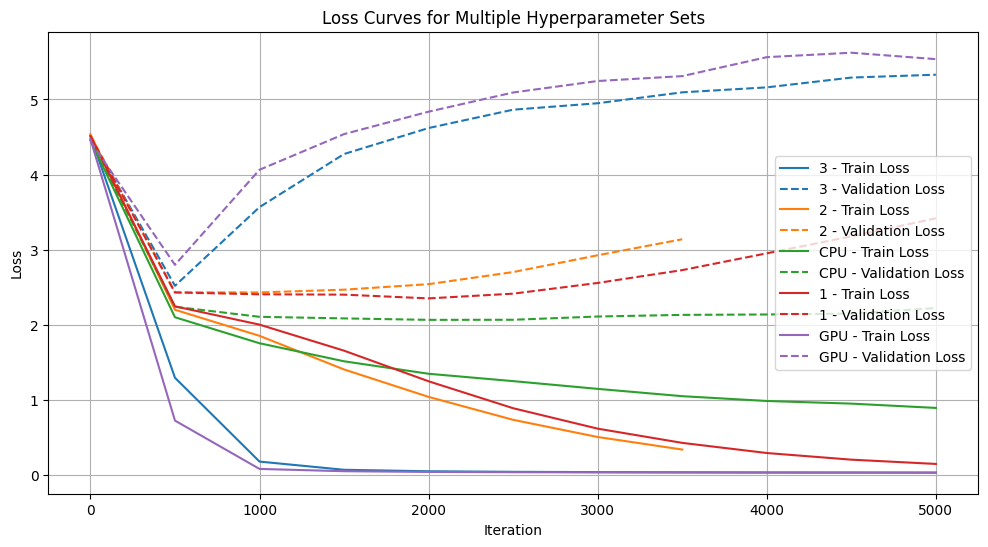

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import glob  # Zum Finden aller CSV-Dateien

# 1. Alle CSV-Dateien finden
csv_files = glob.glob("*.csv")  # Alle CSV-Dateien im aktuellen Verzeichnis

# 2. Daten einlesen und verarbeiten
dataframes = {}
for file in csv_files:
    # Extrahiere den letzten Teil des Dateinamens nach dem letzten "_"
    label = file.split("/")[-1].split(".csv")[0].split("_")[-1]
    df = pd.read_csv(file)
    dataframes[label] = df

# 3. Plot erstellen
plt.figure(figsize=(12, 6))

# Erstelle eine Farbliste für die Kurven
colors = plt.cm.tab10.colors  # Verwende eine vordefinierte Farbkarte
color_map = {label: colors[i % len(colors)] for i, label in enumerate(dataframes.keys())}

# Daten für jedes CSV-Set hinzufügen
for label, df in dataframes.items():
    color = color_map[label]  # Farbe basierend auf dem Label
    plt.plot(df["Iteration"], df["Train Loss"], label=f"{label} - Train Loss", color=color, linestyle="solid")
    plt.plot(df["Iteration"], df["Validation Loss"], label=f"{label} - Validation Loss", color=color, linestyle="dashed")

# Diagramm anpassen
plt.title("Loss Curves for Multiple Hyperparameter Sets")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()